Per episode analysis (for training/validation/testing episode)

In [24]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import json

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.use('Agg')       # Use non-interactive backend for matplotlib to save memory

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

Load the dataset, we need to compute the standard-scalar to look into the prediction of the f-signal

In [4]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [3]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
# convert datetime objects to timezone-naive datetime objects
def convert_to_naive_datetimes_df(df):
    """Convert datetime objects in DataFrame to timezone-naive datetime objects"""
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None) if isinstance(x, datetime) else x)

    return df

def convert_to_naive_datetimes(segments):
    """Convert datetime objects in segments to timezone-naive datetime objects"""
    return [(start.replace(tzinfo=None), end.replace(tzinfo=None)) for start, end in segments]

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [7]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

---

Load the experiment

In [11]:
expt_datetime = datetime(2025, 7, 27, 1, 8, 53)
result_phrase = "train"  # or "test" or "validate"

expt_folder = Path("experiments") / expt_datetime.strftime("%Y%m%d_%H%M%S") / ("logs_" + result_phrase)

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.", "error")

Load the experiment config

Then depends on your data loader, we load the dataset with the corresponding dataloader

In [12]:
env_config_path = expt_folder.parent / "env_config.json"
if not env_config_path.exists():
    print_log(f"Environment config file {env_config_path} does not exist. Please check the path.")

# Load environment configuration
with open(env_config_path, 'r') as f:
    env_config = json.load(f)

# Display environment configuration
print_log("Environment Configuration:")
for key, value in env_config.items():
    print_log(f"{key}: {value}")

[2025-07-27 17:38:56:939] Environment Configuration:
[2025-07-27 17:38:56:939] battery: {'capacity': 8.0, 'max_charging_rate': 4.0, 'max_discharging_rate': 4.0, 'efficiency': 1.0, 'initial_soc': 0.15}
[2025-07-27 17:38:56:939] reward_lambda: 0.5
[2025-07-27 17:38:56:939] h_network_type: HNetworkType.H_NETWORK
[2025-07-27 17:38:56:939] init_soc: 0.15
[2025-07-27 17:38:56:939] data_loader_type: SimpleSmartMeterDataLoader
[2025-07-27 17:38:56:939] curriculum_info: {'curriculum_enabled': False, 'max_episode_days': 1, 'episodes_by_length': {'1': 162}, 'total_episodes': 162, 'registry_path': 'experiments/20250727_010853/simple_episode_registry_train.json', 'data_loader_type': 'simple'}
[2025-07-27 17:38:56:939] training_timestep: 3


In [13]:
from rl_env.data_loader.simple_data_loader import SimpleSmartMeterDataLoader
from rl_env.data_loader.curriculum_data_loader import CurriculumSmartMeterDataLoader

data_loader_type = env_config["curriculum_info"].get("data_loader_type", "simple")

# create dataloader for training set
if data_loader_type == "curriculum":
    sm_dl_train = CurriculumSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_train,
        aggregate_load_df=aggregate_load_df_train,
    )
else:
    sm_dl_train = SimpleSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_train,
        aggregate_load_df=aggregate_load_df_train,
        registry_path=expt_folder / "simple_episode_registry_train.json"
    )


# create dataloader for validation and test sets
if data_loader_type == "curriculum":
    sm_dl_validation = CurriculumSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_validation,
        aggregate_load_df=aggregate_load_df_validation,
    )
    sm_dl_test = CurriculumSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_test,
        aggregate_load_df=aggregate_load_df_test,
    )
else:
    sm_dl_validation = SimpleSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_validation,
        aggregate_load_df=aggregate_load_df_validation,
        registry_path=expt_folder / "simple_episode_registry_validation.json"
    )
    sm_dl_test = SimpleSmartMeterDataLoader(
        aggregate_load_segments=aggregate_load_segments_test,
        aggregate_load_df=aggregate_load_df_test,
        registry_path=expt_folder / "simple_episode_registry_test.json"
    )

[SimpleDataLoader] Generated 162 episodes (1 day each)
[SimpleDataLoader] Generated 73 episodes (1 day each)
[SimpleDataLoader] Generated 80 episodes (1 day each)


In [14]:
from rl_env.hrl_env_episode import SmartMeterEpisode

# construct a SmartMeterEpisode object for each df in SmartMeterDataLoader
sm_episodes_train = list(
    SmartMeterEpisode(
        selected_aggregate_load_df=sm_dl_train.get_aggregate_load_segment(i)
    ) for i in range(sm_dl_train.get_divided_segments_length())
)

In [15]:
max_battery_capacity = env_config.get("battery").get("capacity", 8)
max_battery_capacity

8.0

In [16]:
from collections.abc import MutableMapping

def flatten(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

In [17]:
episode_info_folder = expt_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []
    episode_metadata_list = []  # Store metadata for each episode

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            
            # Extract episode data and metadata (support new format)
            if isinstance(episode_info, dict) and 'episode_data' in episode_info:
                # New format with metadata
                episode_data = episode_info['episode_data']
                metadata = episode_info.get('metadata', {})
                df = pd.DataFrame(episode_data)

                metadata = flatten(metadata)  # Flatten metadata dictionary
                
                # Store metadata for analysis
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    **metadata
                })
            else:
                # Legacy format - just episode data
                df = pd.DataFrame(episode_info)
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    'episode_content_id': None,
                    'episode_length_days': 1,  # Default to 1 day for legacy
                    'curriculum_phase': None,
                    'data_loader_type': 'Unknown'
                })
            
            # add a column for the episode number
            df['episode'] = int(file.stem.split('_')[1])  # Assuming the file name is like "episode_0_info.json", "episode_1_info.json", etc.
            # convert the datetime strings to datetime objects using python isoformat
            df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

            # fix to align with episode_df.pkl
            # we shift "grid_load (W)", "action (kW)", "battery_action (kW)", "reward", "f_signal", "g_signal" columns to the a timestep forward, then drop the last row for each episode
            df['grid_load (W)'] = df['grid_load (W)'].shift(-1)
            df['action (kW)'] = df['action (kW)'].shift(-1)
            df['battery_action (kW)'] = df['battery_action (kW)'].shift(-1)
            df['reward'] = df['reward'].shift(-1)
            df['f_signal'] = df['f_signal'].shift(-1)
            df['g_signal'] = df['g_signal'].shift(-1)
            df['f_signal-predicted_mean'] = df['f_signal-predicted_mean'].shift(-1)
            df['f_signal-predicted_log_var'] = df['f_signal-predicted_log_var'].shift(-1)
            df['f_signal-target'] = df['f_signal-target'].shift(-1)

            # remove the last row for each episode
            df = df[:-1]

            episode_info_dfs.append(df)

            print_log(f"Loaded episode info from {file.name}")

    # Concatenate all DataFrames into one
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    
    # Create episode metadata DataFrame for curriculum analysis
    episode_metadata_df = pd.DataFrame(episode_metadata_list)
    
    print_log(f"Loaded {len(episode_info_dfs)} episodes with enhanced metadata")
    print_log(f"Data loader types found: {episode_metadata_df['curriculum_info_data_loader_type'].value_counts().to_dict()}")
    if 'episode_length_days' in episode_metadata_df.columns:
        print_log(f"Episode lengths found: {episode_metadata_df['episode_length_days'].value_counts().sort_index().to_dict()}")
    # if 'curriculum_phase' in episode_metadata_df.columns and episode_metadata_df['curriculum_phase'].notna().any():
    #     print_log(f"Curriculum phases found: {episode_metadata_df['curriculum_phase'].value_counts().to_dict()}")

[2025-07-27 17:43:59:879] Loaded episode info from episode_0001_info.json
[2025-07-27 17:43:59:889] Loaded episode info from episode_0002_info.json
[2025-07-27 17:43:59:897] Loaded episode info from episode_0003_info.json
[2025-07-27 17:43:59:906] Loaded episode info from episode_0004_info.json
[2025-07-27 17:43:59:914] Loaded episode info from episode_0005_info.json
[2025-07-27 17:43:59:922] Loaded episode info from episode_0006_info.json
[2025-07-27 17:43:59:931] Loaded episode info from episode_0007_info.json
[2025-07-27 17:43:59:939] Loaded episode info from episode_0008_info.json
[2025-07-27 17:43:59:947] Loaded episode info from episode_0009_info.json
[2025-07-27 17:43:59:955] Loaded episode info from episode_0010_info.json
[2025-07-27 17:43:59:963] Loaded episode info from episode_0011_info.json
[2025-07-27 17:43:59:972] Loaded episode info from episode_0012_info.json
[2025-07-27 17:43:59:980] Loaded episode info from episode_0013_info.json
[2025-07-27 17:43:59:988] Loaded episo

---

Approach 1

For each episode, we create two graphs.

The first graph is identical to `plot_episode_details()` in expt_results.ipynb.
 
The second is a graph with two sub-plots. On top is the H-network predicted mean and log_var (if any), and also the target (which is y_{t+1}). On bottom is the resulting H-network signal.

In [18]:
# Let's first examine the structure of the episode data
if episode_info_dfs:
    sample_episode_df = episode_info_dfs[0]
    print("Columns in episode_info_dfs:")
    print(sample_episode_df.columns.tolist())
    print("\nFirst few rows of sample episode:")
    print(sample_episode_df.head())
    print(f"\nNumber of episodes available: {len(episode_info_dfs)}")

Columns in episode_info_dfs:
['episode_index', 'current_step', 'datetime', 'battery_soc (%)', 'battery_soc (kWh)', 'user_load (W)', 'grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 'f_signal', 'g_signal', 'f_signal-predicted_mean', 'f_signal-predicted_log_var', 'f_signal-target', 'TimeLimit.truncated', 'episode']

First few rows of sample episode:
   episode_index  current_step            datetime  battery_soc (%)  \
0             96             0 2013-08-28 00:00:02         0.150000   
1             96             1 2013-08-28 00:01:02         0.149367   
2             96             2 2013-08-28 00:02:02         0.148738   
3             96             3 2013-08-28 00:03:02         0.148108   
4             96             4 2013-08-28 00:04:02         0.147466   

   battery_soc (kWh)  user_load (W)  grid_load (W)  action (kW)  \
0           1.200000     304.000000   0.000000e+00    -2.414689   
1           1.194933     301.620664   5.684342e-14    -3.350458   
2     

In [19]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


def plot_episode_overview(episode_df, episode_idx, save_path=None, use_datetime=False, show=True):
    """
    Plot episode overview combining load profiles, battery SOC, and H-network output signals
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # First subplot: User load and Grid load (from plot_episode_details)
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='pink', linewidth=2, alpha=0.8)

    ax1.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Load Profiles Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Battery SOC with color coding using LineCollection (from plot_episode_details)
    soc_values = episode_df['battery_soc (kWh)'].values
    
    # Calculate SOC changes
    soc_changes = np.diff(soc_values)
    
    # Create numerical color array based on SOC changes for smooth coloring
    # -1: red (decreasing), 0: blue (no change), 1: green (increasing)
    color_values = []
    for change in soc_changes:
        if change > 1e-6:  # Small threshold to handle floating point precision
            color_values.append(1)    # SOC increases (green)
        elif change < -1e-6:
            color_values.append(-1)   # SOC decreases (red)
        else:
            color_values.append(0)    # No change (blue)
    
    # Create line segments for LineCollection
    if use_datetime and 'datetime' in episode_df.columns:
        # Convert datetime to matplotlib date numbers for LineCollection
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create LineCollection with custom colormap
    lc = LineCollection(segments, linewidth=3, capstyle='round')
    lc.set_array(np.array(color_values))
    
    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)
    
    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)
    
    # Add the line collection to the plot
    line = ax2.add_collection(lc)

    ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Battery State of Charge Over Time')
    ax2.set_ylabel('SOC (kWh)')
    ax2.grid(True, alpha=0.3)
    
    # Set axis limits for better visualization
    if use_datetime and 'datetime' in episode_df.columns:
        ax2.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax2.set_xlim(0, len(episode_df)-1)
    ax2.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)
    
    # Add legend for SOC colors
    legend_elements = [Patch(facecolor='green', label='SOC Increasing'),
                      Patch(facecolor='red', label='SOC Decreasing'),
                      Patch(facecolor='blue', label='SOC No Change')]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Third subplot: H-network output signals (f_signal and g_signal) (from plot_h_network_predictions)
    # Remove NaN values for plotting
    signal_valid_mask = ~(episode_df['f_signal'].isna() | episode_df['g_signal'].isna())
    
    if use_datetime and 'datetime' in episode_df.columns:
        x_signal_valid = episode_df.loc[signal_valid_mask, 'datetime']
    else:
        x_signal_valid = np.array(x_values)[signal_valid_mask]
    
    f_signal = episode_df.loc[signal_valid_mask, 'f_signal']
    g_signal = episode_df.loc[signal_valid_mask, 'g_signal']
    
    ax3.plot(x_signal_valid, f_signal, label='f_signal', color='green', linewidth=2)
    ax3.plot(x_signal_valid, g_signal, label='g_signal', color='purple', linewidth=2)
    
    ax3.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: H-network Output Signals')
    ax3.set_xlabel(x_label)
    ax3.set_ylabel('Signal Value')
    ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        # Format the datetime axis
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

In [20]:
def plot_h_network_loss_analysis(episode_df, episode_idx, save_path=None, use_datetime=False, show=True):
    """
    Plot H-network loss analysis with predictions, computed loss, likelihood, and f_signal
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    import torch
    import torch.nn as nn
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # First subplot: H-network predicted mean, log_var, and target (identical to plot_h_network_predictions)
    # Remove NaN values for plotting
    valid_mask = ~(episode_df['f_signal-predicted_mean'].isna() | 
                   episode_df['f_signal-predicted_log_var'].isna() | 
                   episode_df['f_signal-target'].isna())
    
    if use_datetime and 'datetime' in episode_df.columns:
        x_valid = episode_df.loc[valid_mask, 'datetime']
    else:
        x_valid = np.array(x_values)[valid_mask]
    
    predicted_mean = episode_df.loc[valid_mask, 'f_signal-predicted_mean']
    predicted_log_var = episode_df.loc[valid_mask, 'f_signal-predicted_log_var']
    target = episode_df.loc[valid_mask, 'f_signal-target']
    
    # Plot predicted mean
    ax1.plot(x_valid, predicted_mean, label='H-network Predicted Mean', color='blue', linewidth=2)
    
    # Plot predicted log variance (if available)
    if not predicted_log_var.isna().all():
        ax1.plot(x_valid, predicted_log_var, label='H-network Predicted Log Var', color='orange', linewidth=2, alpha=0.7)
        
        # Add confidence interval using log variance
        predicted_std = np.sqrt(np.exp(predicted_log_var))
        ax1.fill_between(x_valid, 
                        predicted_mean - predicted_std, 
                        predicted_mean + predicted_std, 
                        alpha=0.2, color='blue', label='Predicted ±1σ')
    
    # Plot target
    ax1.plot(x_valid, target, label='Target (y_{t+1}) = std user load', color='red', linewidth=2, linestyle='--')
    
    ax1.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: H-network Predictions vs Target')
    ax1.set_ylabel('Signal Value')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Loss, Likelihood, and f_signal analysis
    # Compute GaussianNLLLoss and likelihood
    if not (predicted_mean.isna().all() or predicted_log_var.isna().all() or target.isna().all()):
        # Convert to torch tensors for loss computation
        mean_tensor = torch.tensor(predicted_mean.values, dtype=torch.float32)
        var_tensor = torch.exp(torch.tensor(predicted_log_var.values, dtype=torch.float32))
        target_tensor = torch.tensor(target.values, dtype=torch.float32)
        
        # Compute GaussianNLLLoss
        loss_fn = nn.GaussianNLLLoss(reduction='none')  # 'none' to get per-sample loss
        computed_loss = loss_fn(mean_tensor, target_tensor, var_tensor).detach().numpy()
        
        # Compute likelihood: exp(-loss)
        likelihood = np.exp(-computed_loss)
        
        # Get f_signal (which should be likelihood * (-loss) according to the description)
        # f_signal_mask = ~episode_df['f_signal'].isna()
        # if use_datetime and 'datetime' in episode_df.columns:
        #     x_f_signal = episode_df.loc[f_signal_mask, 'datetime']
        # else:
        #     x_f_signal = np.array(x_values)[f_signal_mask]
        
        # f_signal_values = episode_df.loc[f_signal_mask, 'f_signal']
        
        # Also compute the product of likelihood and negative loss for comparison
        likelihood_neg_loss_product = likelihood * (-computed_loss)
        
        # Plot computed loss
        ax2.plot(x_valid, computed_loss, label='Computed Loss (GaussianNLLLoss)', 
                color='red', linewidth=2, alpha=0.8)
        
        # Plot likelihood
        ax2.plot(x_valid, likelihood, label='Likelihood (exp(-loss))', 
                color='green', linewidth=2, alpha=0.8)
        
        # Plot likelihood * (-loss) product
        ax2.plot(x_valid, likelihood_neg_loss_product, label='Likelihood × (-Loss) = f_signal', 
                color='purple', linewidth=2, alpha=0.7, linestyle='--')
        
        # Plot actual f_signal for comparison
        # ax2.plot(x_f_signal, f_signal_values, label='Actual f_signal', 
        #         color='darkblue', linewidth=2, alpha=0.9, linestyle=':')
        
        ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: H-network Loss and Likelihood Analysis')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Value')
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    else:
        # If no valid data, show empty plot with message
        ax2.text(0.5, 0.5, 'No valid data for loss analysis', 
                transform=ax2.transAxes, ha='center', va='center', fontsize=14)
        ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: H-network Loss and Likelihood Analysis')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Value')
        ax2.grid(True, alpha=0.3)
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        # Format the datetime axis
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

In [25]:
# Create two graphs for each episode
def create_episode_analysis_plots(episode_dfs_list, episodes_to_plot=None, save_plots=(True, True), use_datetime=True, show_plots=False):
    """
    Create two graphs for each episode:
    1. Episode overview (load profiles, battery SOC, and H-network signals)
    2. H-network loss analysis (loss, likelihood, and f_signal comparison)
    
    Args:
        episode_dfs_list: List of episode DataFrames
        episodes_to_plot: List of episode indices to plot. If None, plots all episodes.
        save_plots: Tuple indicating whether to save each of the two plots
        use_datetime: Whether to use datetime as x-axis
        show_plots: Whether to display the plots
    """
    if episodes_to_plot is None:
        episodes_to_plot = list(range(0, len(episode_dfs_list)))
    
    print_log(f"Creating analysis plots for {len(episodes_to_plot)} episodes...")
    
    for i in episodes_to_plot:
        if i >= len(episode_dfs_list):
            print_log(f"Skipping episode index {i} - out of range", "warning")
            continue
            
        episode_df = episode_dfs_list[i]
        episode_idx = episode_df['episode_index'].iloc[0]  # Get the actual episode index
        episode_ittr = episode_df['episode'].iloc[0]       # Get the episode iteration number
        
        print_log(f"Processing episode {episode_idx} @ iteration {episode_ittr}...")
        
        # Create save directories if saving plots
        if save_plots:
            episode_overview_dir = expt_folder / "graphs" / "per_episode_analysis" / "episode_overview"
            h_network_loss_dir = expt_folder / "graphs" / "per_episode_analysis" / "h_network_loss_analysis"
            
            episode_overview_dir.mkdir(parents=True, exist_ok=True)
            h_network_loss_dir.mkdir(parents=True, exist_ok=True)
            
            episode_overview_path = episode_overview_dir / f"episode_{i+1:04d}_overview.png"
            h_network_loss_path = h_network_loss_dir / f"episode_{i+1:04d}_h_network_loss_analysis.png"
        else:
            episode_overview_path = None
            h_network_loss_path = None
        
        # Graph 1: Episode overview (load profiles, battery SOC, and H-network signals)
        print_log(f"  Creating episode overview plot...")
        fig1 = plot_episode_overview(
            episode_df, 
            episode_idx, 
            save_path=episode_overview_path if save_plots[0] else None, 
            use_datetime=use_datetime, 
            show=show_plots
        )
        
        # Graph 2: H-network loss analysis
        print_log(f"  Creating H-network loss analysis plot...")
        fig2 = plot_h_network_loss_analysis(
            episode_df, 
            episode_idx, 
            save_path=h_network_loss_path if save_plots[1] else None, 
            use_datetime=use_datetime, 
            show=show_plots
        )
        
        # Close figures to free memory if not showing
        if not show_plots:
            plt.close(fig1)
            plt.close(fig2)

            # free memory
            del fig1, fig2
    
    print_log("Completed creating all episode analysis plots!")

In [26]:
create_episode_analysis_plots(
    episode_info_dfs, 
    episodes_to_plot=list(range(0, len(episode_info_dfs))),  # Plot all episodes
    save_plots=(True, True),  # Save only H-network predictions and loss analysis
    use_datetime=True, 
    show_plots=False
)

[2025-07-27 17:45:50:905] Creating analysis plots for 605 episodes...
[2025-07-27 17:45:50:905] Processing episode 96 @ iteration 1...
[2025-07-27 17:45:50:906]   Creating episode overview plot...
[2025-07-27 17:45:51:925]   Creating H-network loss analysis plot...
[2025-07-27 17:45:53:347] Processing episode 8 @ iteration 2...
[2025-07-27 17:45:53:348]   Creating episode overview plot...
[2025-07-27 17:45:54:307]   Creating H-network loss analysis plot...
[2025-07-27 17:45:54:906] Processing episode 147 @ iteration 3...
[2025-07-27 17:45:54:907]   Creating episode overview plot...
[2025-07-27 17:45:56:003]   Creating H-network loss analysis plot...
[2025-07-27 17:45:56:603] Processing episode 35 @ iteration 4...
[2025-07-27 17:45:56:604]   Creating episode overview plot...
[2025-07-27 17:45:57:585]   Creating H-network loss analysis plot...
[2025-07-27 17:45:58:173] Processing episode 41 @ iteration 5...
[2025-07-27 17:45:58:174]   Creating episode overview plot...
[2025-07-27 17:45:5

In [ ]:
# Create plots for all episodes or specific ranges
# Uncomment and modify the lines below based on your needs

# Option 1: Create plots for all episodes (WARNING: This may take a long time!)
# print_log("Creating plots for ALL episodes - this may take a while...")
# create_episode_analysis_plots(
#     episode_info_dfs, 
#     episodes_to_plot=None,  # None means all episodes
#     save_plots=True, 
#     use_datetime=True, 
#     show_plots=False  # Set to False to avoid showing all plots
# )

# Option 2: Create plots for a specific range of episodes (e.g., first 50)
print_log("Creating plots for first 50 episodes...")
create_episode_analysis_plots(
    episode_info_dfs, 
    episodes_to_plot=list(range(min(50, len(episode_info_dfs)))), 
    save_plots=True, 
    use_datetime=True, 
    show_plots=False
)

# Option 3: Create plots for specific episodes of interest
# episodes_of_interest = [0, 10, 50, 100, 500, 800]  # Modify this list as needed
# print_log(f"Creating plots for specific episodes: {episodes_of_interest}")
# create_episode_analysis_plots(
#     episode_info_dfs, 
#     episodes_to_plot=episodes_of_interest, 
#     save_plots=True, 
#     use_datetime=True, 
#     show_plots=False
# )

print_log("All episode analysis plots have been created and saved!")

## Usage Documentation

The code above provides three main plotting functions for per-episode analysis:

### 1. `plot_episode_overview(episode_df, episode_idx, save_path=None, use_datetime=False, show=True)`
- **NEW: Comprehensive episode overview function**
- Creates a 3-subplot graph combining the most important episode information:
  - **Top**: User load (blue) and Grid load masked (pink)
  - **Middle**: Battery State of Charge with color coding (green=increasing, red=decreasing, blue=no change)
  - **Bottom**: H-network output signals f_signal (green) and g_signal (purple)
- This eliminates the need for separate load profiles and H-network signals plots

### 2. `plot_h_network_loss_analysis(episode_df, episode_idx, save_path=None, use_datetime=False, show=True)`
- **Advanced H-network analysis function**
- Creates a 2-subplot graph showing detailed H-network analysis:
  - **Top**: H-network predicted mean (blue), predicted log variance (orange), target y_{t+1} (red dashed), and confidence interval (blue shaded area)
  - **Bottom**: Computed loss (red), likelihood (green), and likelihood × (-loss) product (purple dashed) which equals f_signal

### 3. `create_episode_analysis_plots(episode_dfs_list, episodes_to_plot=None, save_plots=(True, True), use_datetime=True, show_plots=False)`
- **Main wrapper function** that creates two comprehensive graphs for multiple episodes
- **Updated to create only 2 graphs instead of 3** (eliminating redundancy)
- Automatically handles directory creation and file naming
- Saves plots in organized folder structure:
  - `episode_overview/`: Contains comprehensive episode overview plots
  - `h_network_loss_analysis/`: Contains detailed H-network loss analysis plots

### Parameters:
- `episode_df`: Single episode DataFrame from `episode_info_dfs[idx]`
- `episode_idx`: Episode index for title display
- `episodes_to_plot`: List of indices to plot (e.g., `[0, 1, 2]` or `range(50)`)
- `save_path`: Path to save individual plots (optional)
- `use_datetime`: Use datetime x-axis (True) or step numbers (False)
- `show_plots`: Display plots interactively (True) or save only (False)
- `save_plots`: Tuple indicating whether to save each of the two plots `(overview, loss_analysis)`

### Updated File Structure:
```
experiments/{experiment_datetime}/logs_{phase}/graphs/per_episode_analysis/
├── episode_overview/
│   ├── episode_0001_overview.png
│   ├── episode_0002_overview.png
│   └── ...
└── h_network_loss_analysis/
    ├── episode_0001_h_network_loss_analysis.png
    ├── episode_0002_h_network_loss_analysis.png
    └── ...
```

### Example Usage:
```python
# Single episode analysis
episode_df = episode_info_dfs[0]
episode_idx = episode_df['episode_index'].iloc[0]

# Create comprehensive episode overview plot
plot_episode_overview(episode_df, episode_idx, use_datetime=True)

# Create detailed H-network loss analysis plot
plot_h_network_loss_analysis(episode_df, episode_idx, use_datetime=True)

# Batch processing for multiple episodes
create_episode_analysis_plots(
    episode_info_dfs, 
    episodes_to_plot=[0, 10, 50, 100], 
    save_plots=(True, True),  # Save both overview and loss analysis plots
    use_datetime=True, 
    show_plots=False
)

# Save only overview plots for many episodes (faster)
create_episode_analysis_plots(
    episode_info_dfs, 
    episodes_to_plot=range(0, 100), 
    save_plots=(True, False),  # Save only overview plots
    show_plots=False
)
```

### Key Improvements:
✅ **Eliminates duplicate subplots** - No redundant H-network predictions subplot  
✅ **More efficient** - Creates comprehensive overview in single plot  
✅ **Better organization** - Clear separation between overview and detailed analysis  
✅ **Flexible saving options** - Can selectively save different plot types  
✅ **Maintains all functionality** - All original analysis capabilities preserved

[2025-07-21 17:17:43:301] Testing the new H-network loss analysis function...
[2025-07-21 17:17:43:301] Creating loss analysis plot for episode 96...


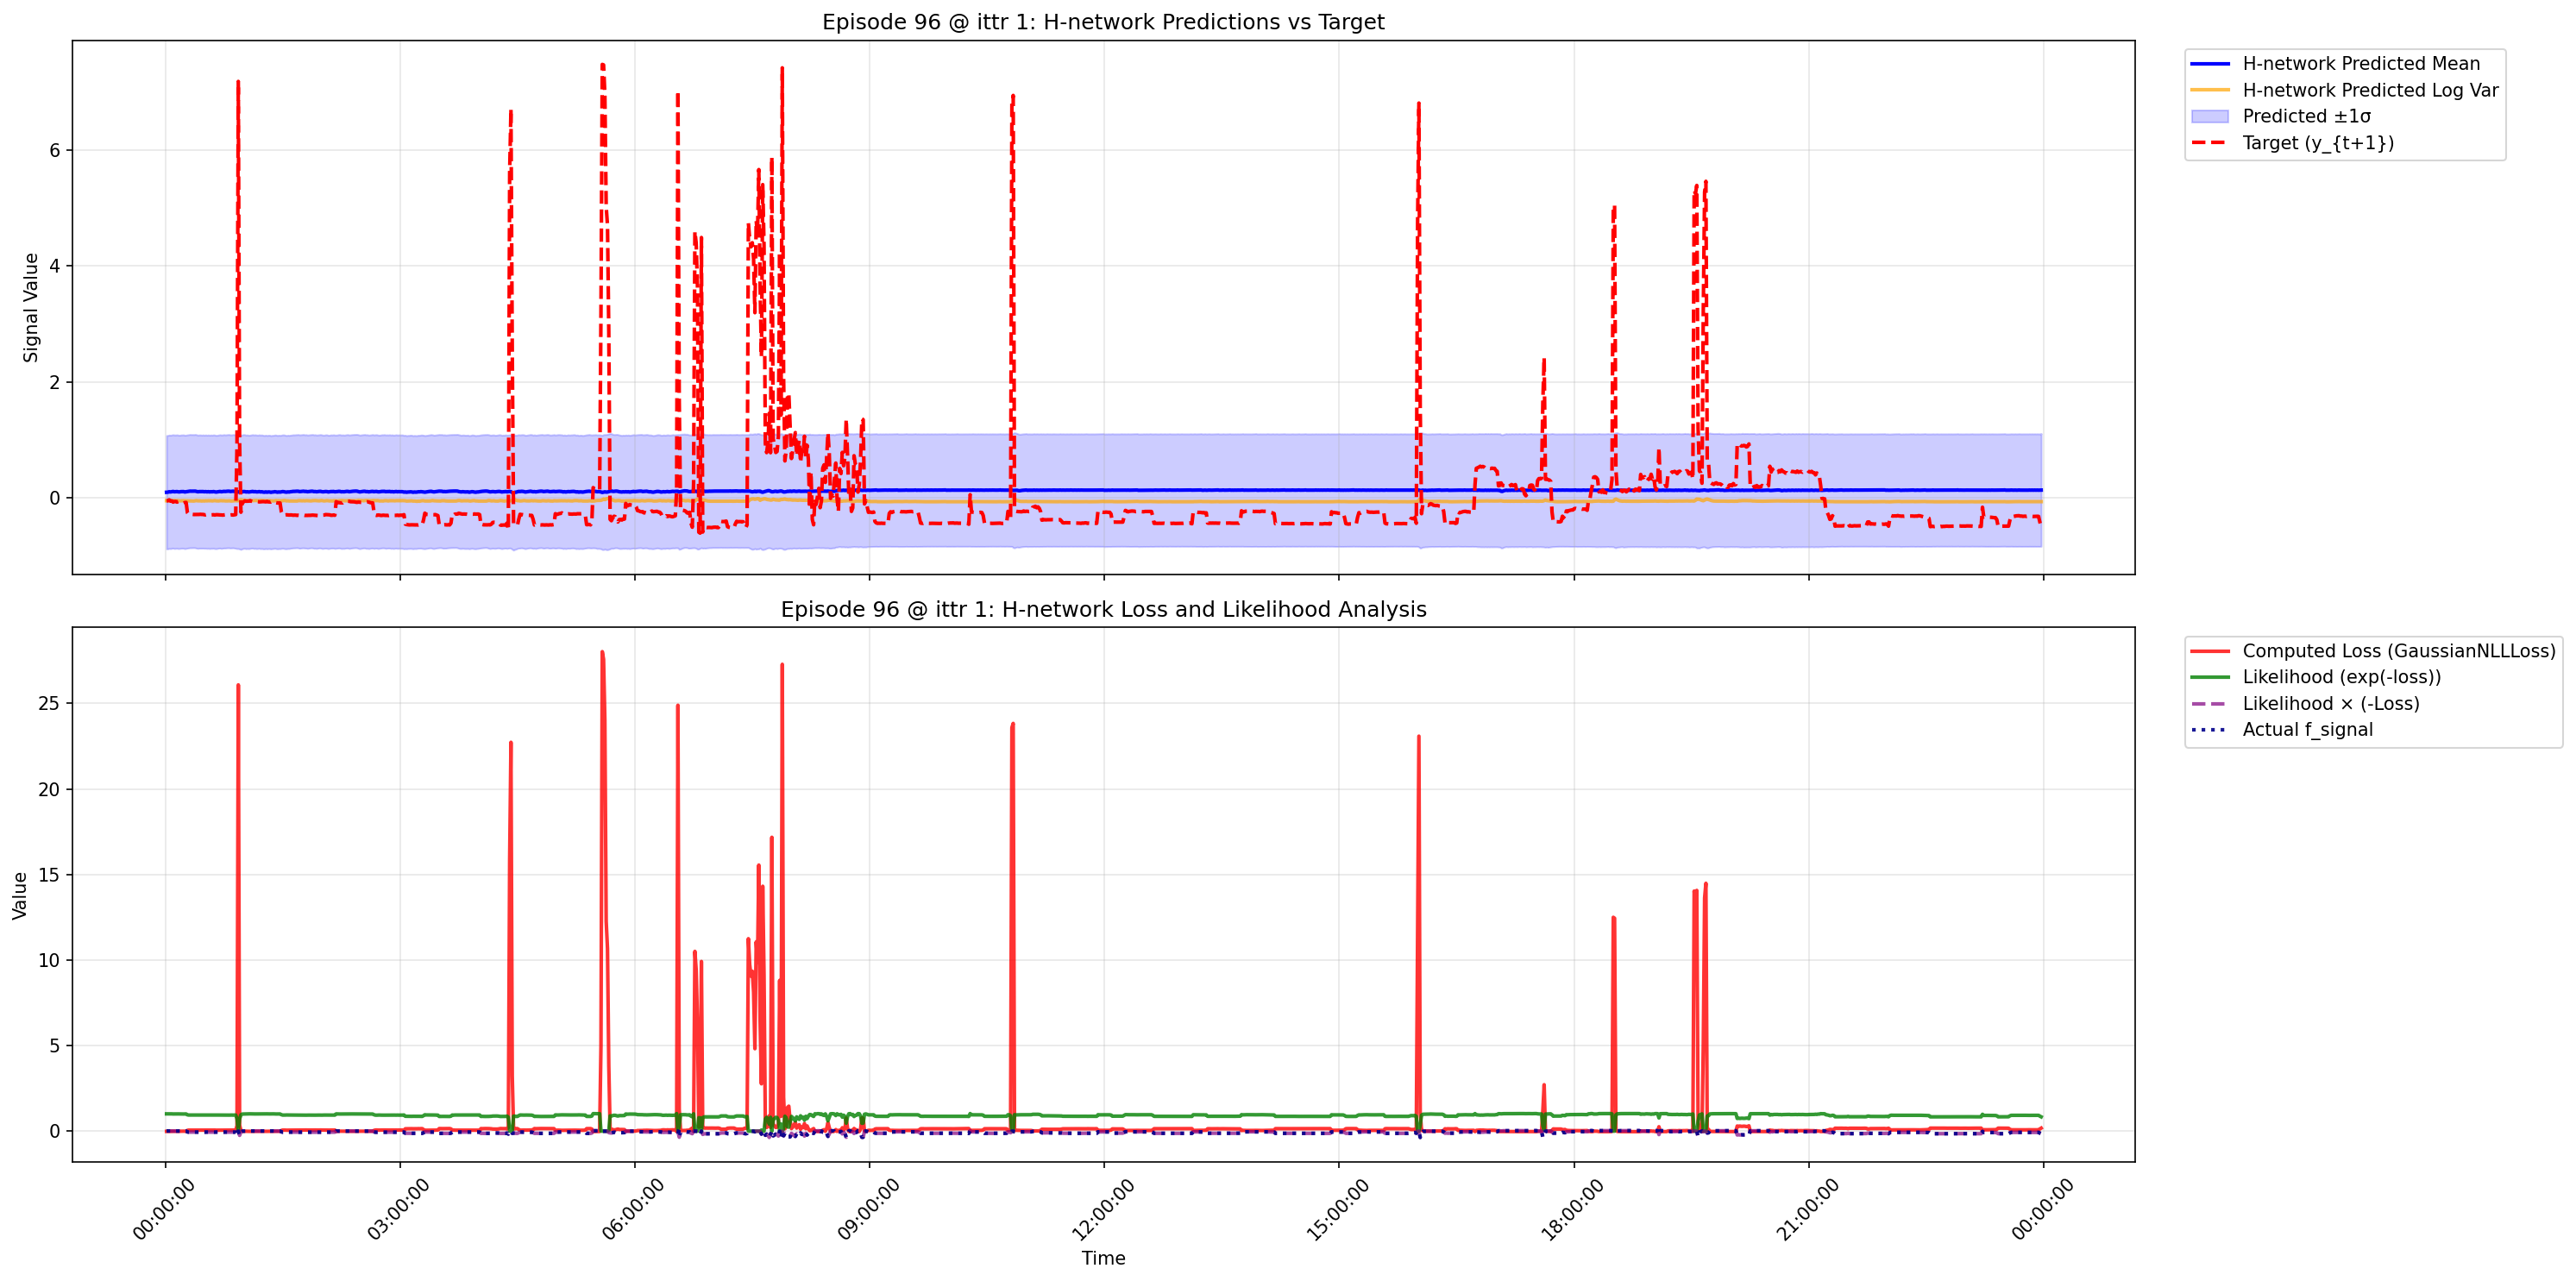

In [26]:
# Test the new H-network loss analysis function
print_log("Testing the new H-network loss analysis function...")

# Test with a single episode
episode_df = episode_info_dfs[0]
episode_idx = episode_df['episode_index'].iloc[0]

print_log(f"Creating loss analysis plot for episode {episode_idx}...")
fig = plot_h_network_loss_analysis(
    episode_df, 
    episode_idx, 
    use_datetime=True, 
    show=True
)

[2025-07-21 17:13:15:205] Testing the updated create_episode_analysis_plots function with all three plots...
[2025-07-21 17:13:15:205] Creating analysis plots for 2 episodes...
[2025-07-21 17:13:15:205] Processing episode 96 @ iteration 1...
[2025-07-21 17:13:15:205]   Creating load profiles plot...


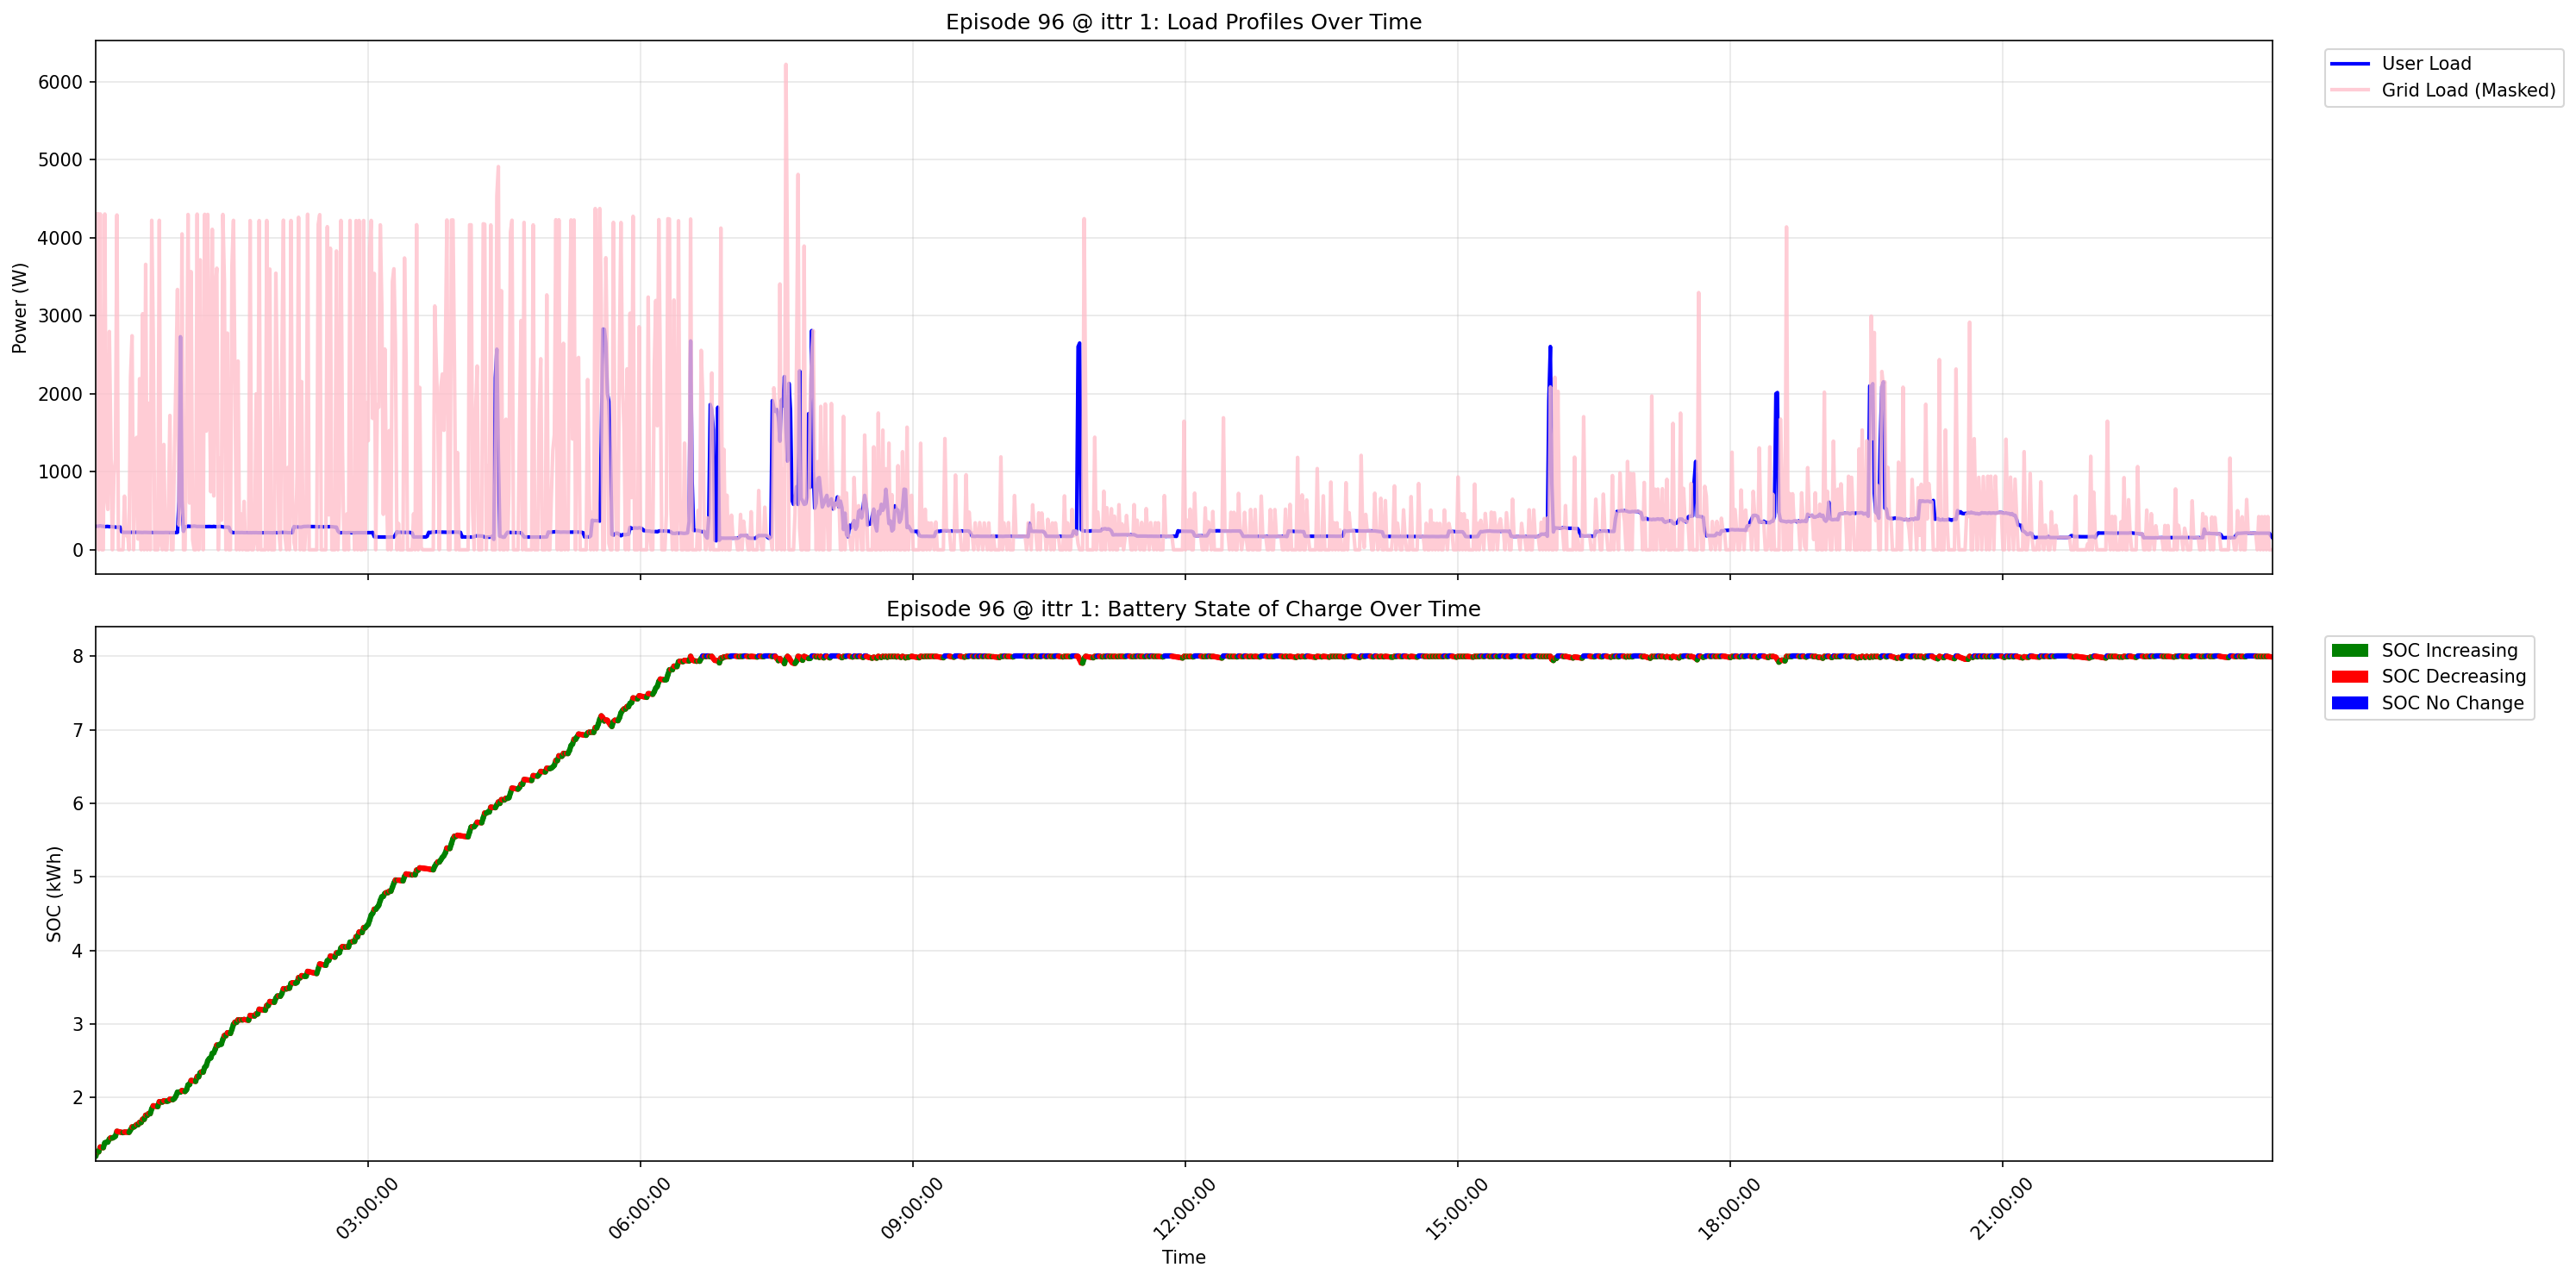

[2025-07-21 17:13:16:119]   Creating H-network predictions plot...


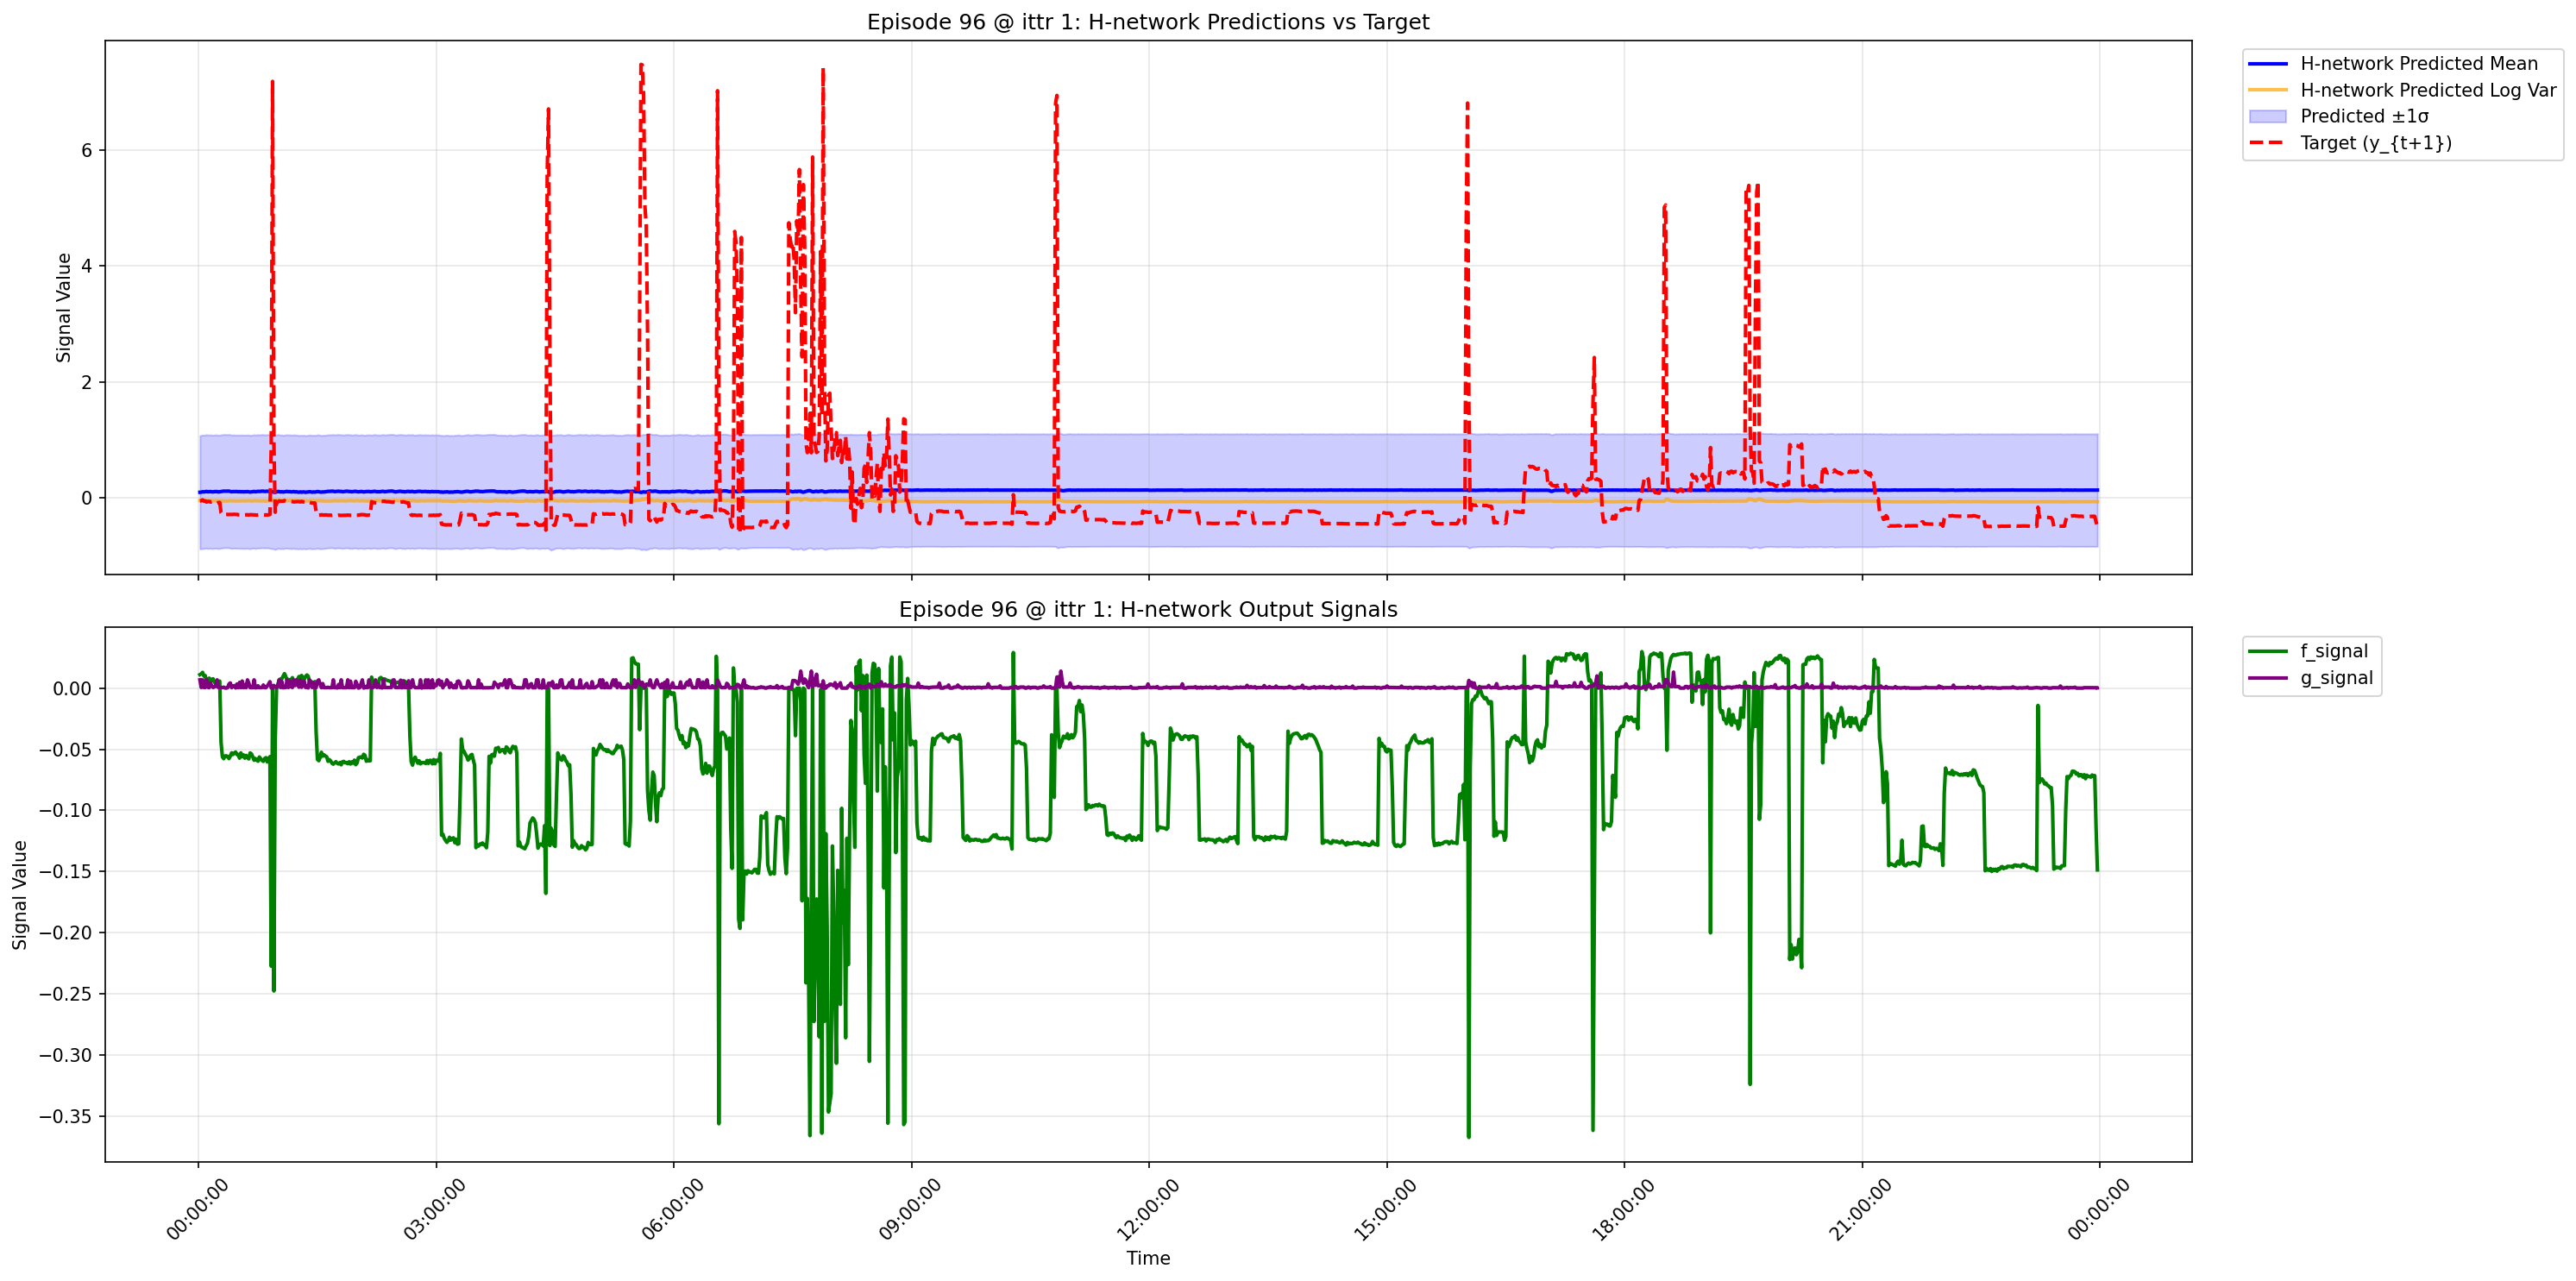

[2025-07-21 17:13:16:980] Processing episode 8 @ iteration 2...
[2025-07-21 17:13:16:980]   Creating load profiles plot...


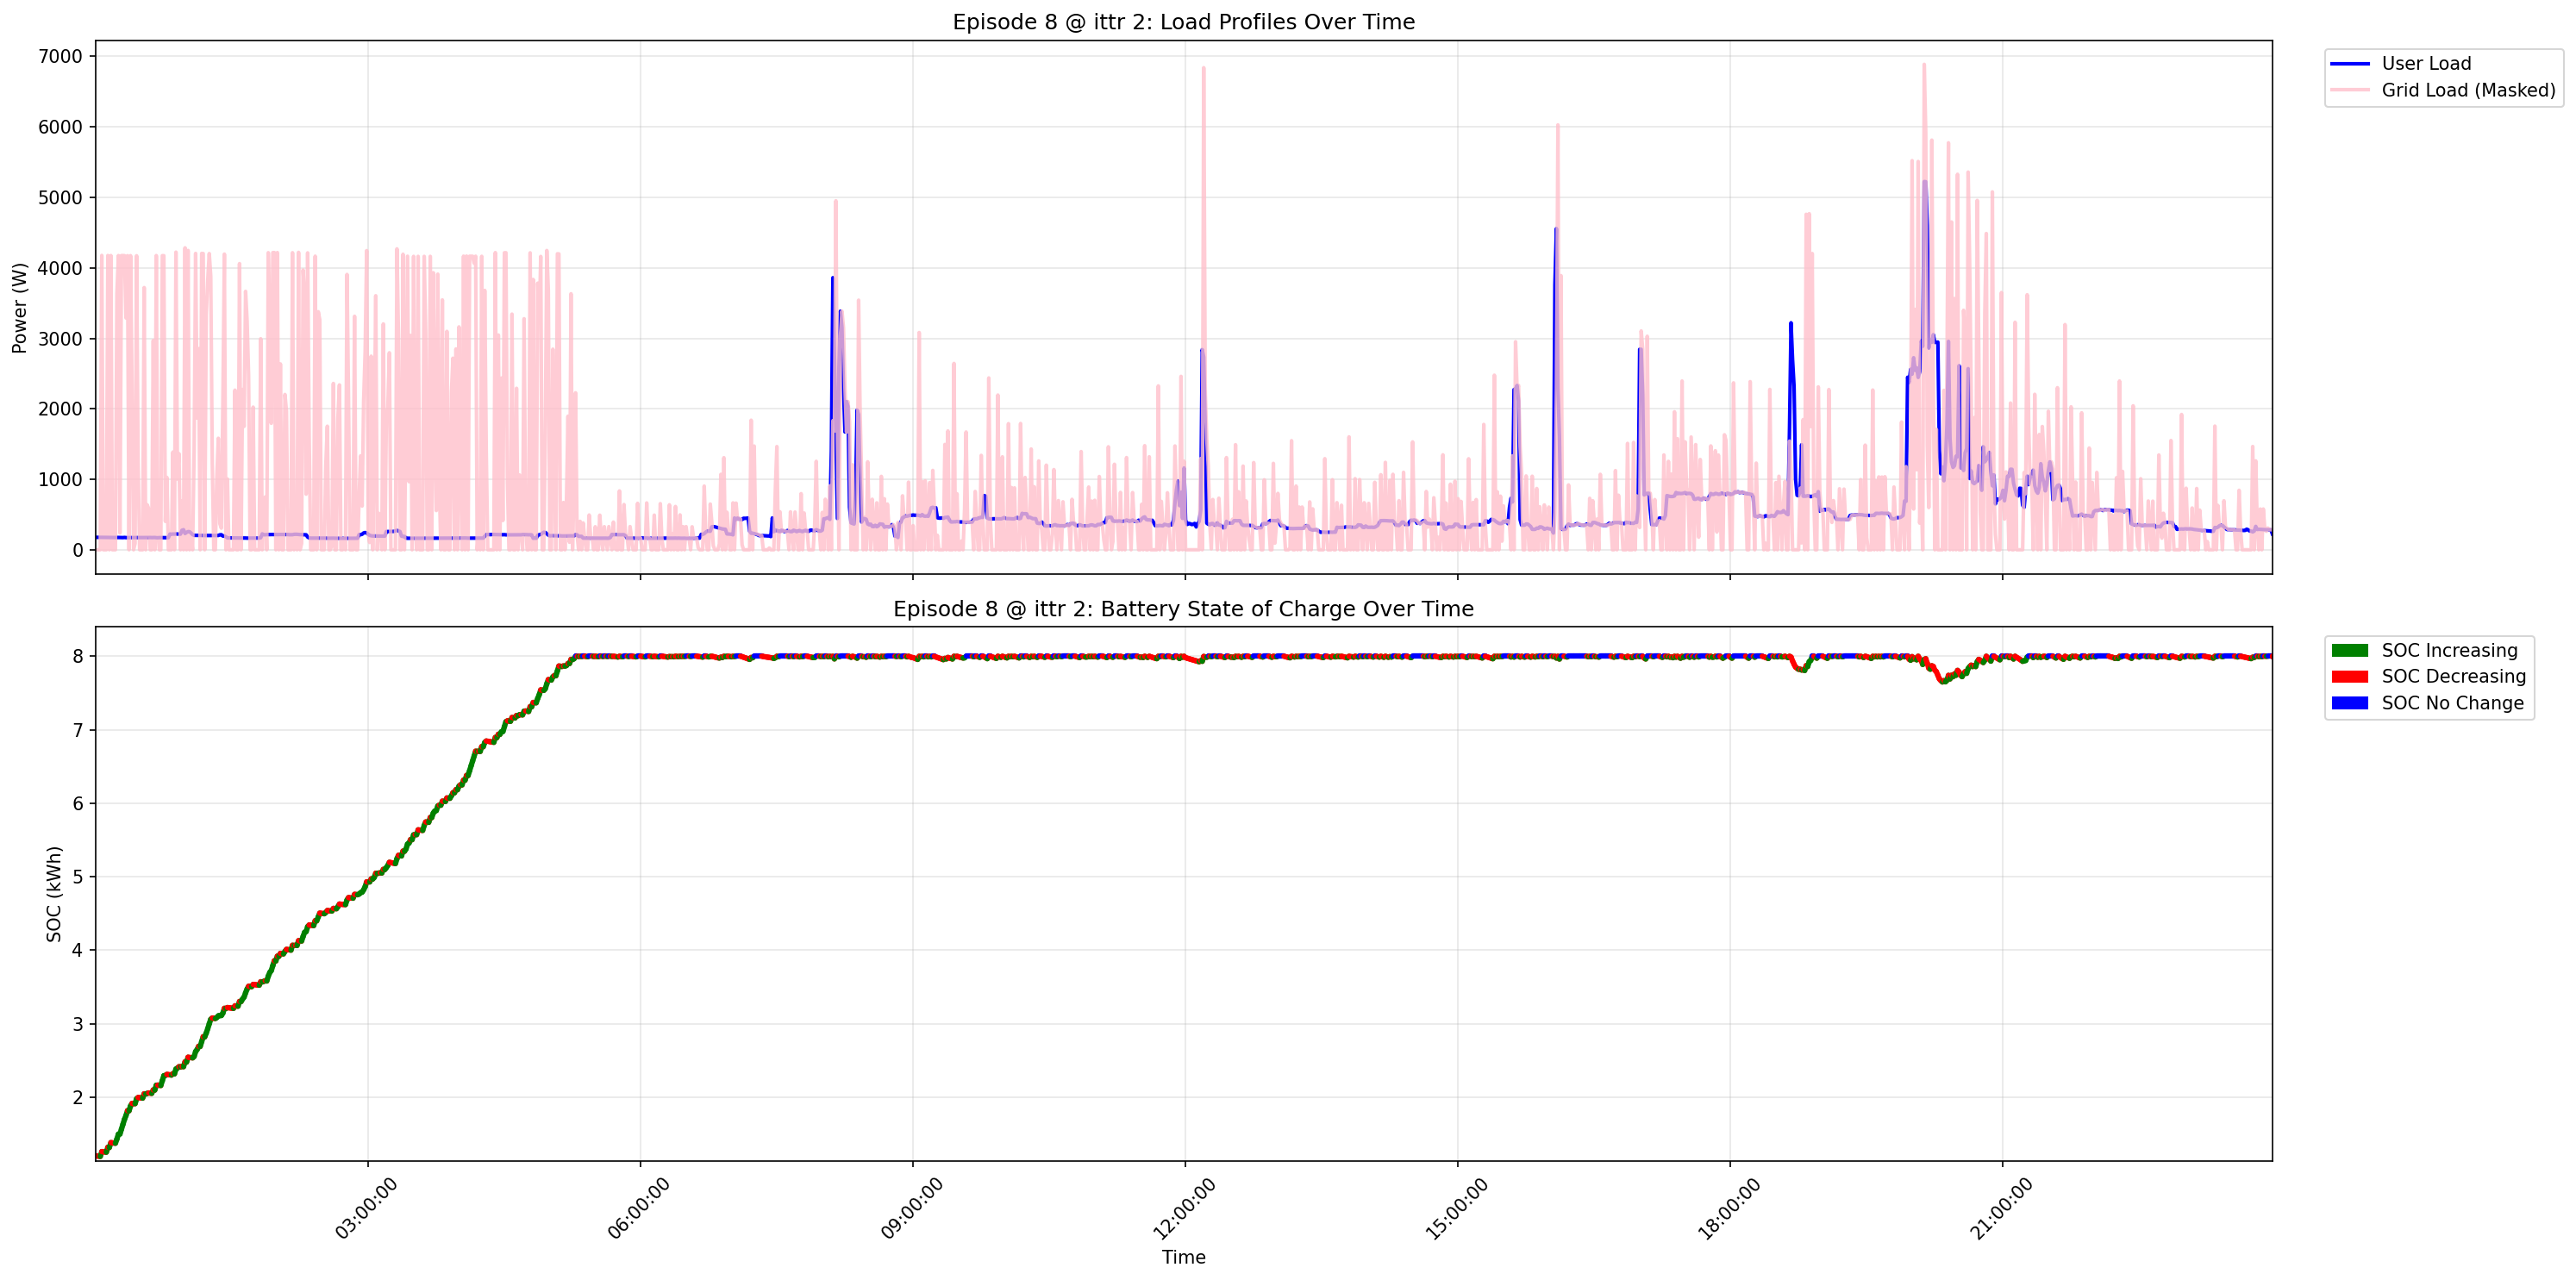

[2025-07-21 17:13:17:881]   Creating H-network predictions plot...


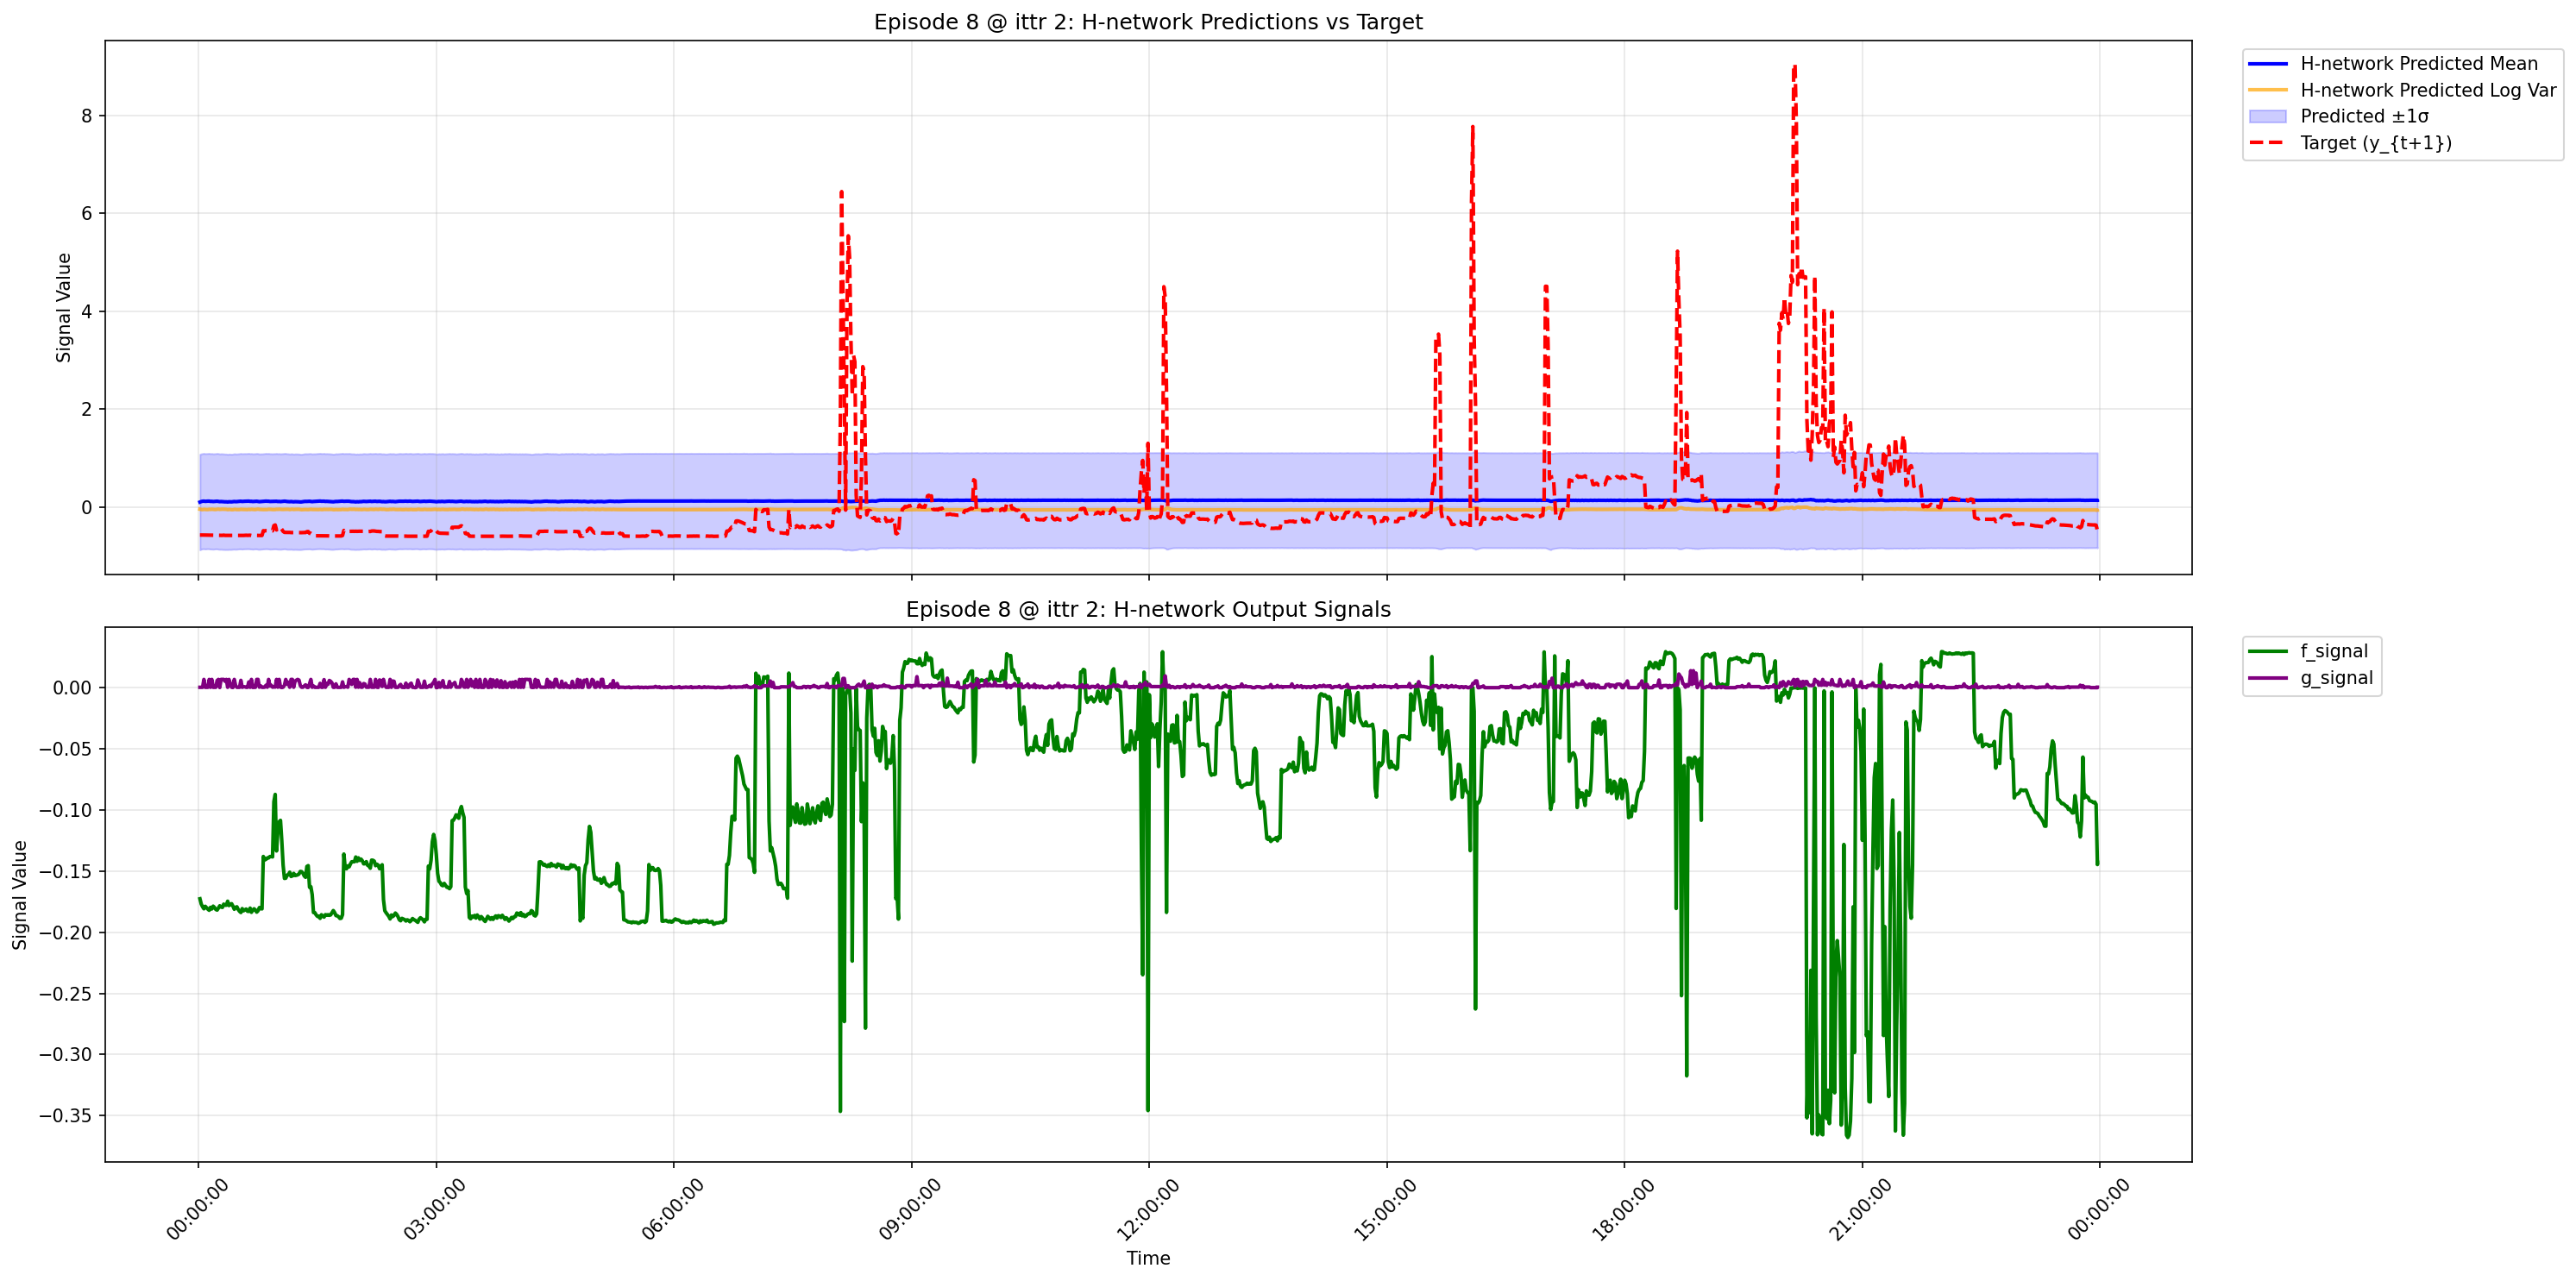

[2025-07-21 17:13:18:754] Completed creating all episode analysis plots!


In [25]:
# Test the updated create_episode_analysis_plots function with all three plots
print_log("Testing the updated create_episode_analysis_plots function with all three plots...")

# Test with just 2 episodes to see all three plots
create_episode_analysis_plots(
    episode_info_dfs, 
    episodes_to_plot=[0, 1],  # Just first 2 episodes for testing
    save_plots=True, 
    use_datetime=True, 
    show_plots=True  # Show plots to verify they work
)